<a href="https://colab.research.google.com/github/smomtahe/GANs_Generative-Adversarial-Networks/blob/main/Deep_Convolutional_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Deep Convolutional GANs # Tensorflow
# For Adversarial Networks (generator and discriminator): 1- Convelutional layers 2- Transposed convelutional layers
import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.layers import Add, Dense, ReLU, Reshape, LeakyReLU

In [19]:
(train_images,_),(_,_)=tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [20]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')  # reshape each image: 28x28x1
train_images=(train_images-127.5)/127.5 #every pixel's intensity value : -1 and 1
train_images.shape

(60000, 28, 28, 1)

In [21]:
buffer_size=60000
batch_size=32

In [22]:
# load data in batches
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)


In [27]:
def generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, input_shape=(100,)))
  # 1st klayer: a fully connected dense layer, 7 7 256 neurons # every vector has a 100 elements
  # input is cast to 4 dimensions 1- batchsize is the 1st d and remaining d are 7*7*256
  # output of this layer is a flattened vector : size 7*7*256 -> vector pass thtough a batch normalization layer (recenter our data to have a mean of zero & variants of 1)

  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7,7,256))) # reshape the input to be in 4d: batch is 1st dimension and 3 d: 7*7*256-> start of the conv stack

  # transposed conv layers: from upsampling of data
  model.add(layers.Conv2DTranspose(128,(5,5),strides=[1,1],padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=[2,2],padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # produces an upsample img (tanh ensures img pixel values are in hte range -1 to 1) of the same size as the img from our real dataset (img: 28*28*1)
  model.add(layers.Conv2DTranspose(1, (5,5),strides=[2,2], padding='same', activation='tanh'))

  return model
# performs upsampling of input data from a noise vector (d:100) to an actual generated img
# use strided convolusions

In [28]:
generator = generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819328    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)        

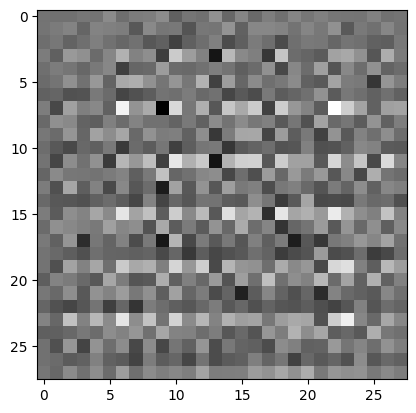

In [29]:
noise=tf.random.normal([1,100])  # generate Gaussian noise: vector size is 100= input dimension of our generator model
generated_image=generator(noise,training=False)  # False: see the generated img looks like
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [36]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5*5),strides=(2*2), padding= 'same',input_shape=[28,28,1]))

    model.add(layers.BatchNormalization()) # reset the output to have mean of 0 and variance of 1
    model.add(layers.LeakyReLU(0.2)) # slight gradient for input values below zero: controlled by the input argument (o.2) that we pass into LR
    model.add(layers.Dropout(0.3)) # dropout: overfitting : turning off a % of neurons in the layer

    model.add(layers.Conv2D(128,(5*5),strides=(2*2), padding= 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) # single probability score: represent the prob that input img is real - sigmoid : prob score : 0-1

    return model


In [34]:
discriminator=discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 64)          40064     
                                                                 
 batch_normalization_6 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 64)          0         
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         5120128   
                                                                 
 batch_normalization_7 (Bat  (None, 2, 2, 128)         512       
 chNormalization)                                     

In [35]:
discriminator=discriminator_model()
output=discriminator(generated_image)
print(output)


tf.Tensor([[0.49981254]], shape=(1, 1), dtype=float32)


In [37]:
bce=tf.keras.losses.BinaryCrossentropy()  # loss function

In [39]:
def discriminator_loss(real_output,fake_output):
  # 2 classes 1: real and 0:fake # imgs from real dataset classfied as real
  real_loss=bce(tf.ones_like(real_output),real_output) # compare output of discriminator to a tensor of 1s, this loss = real loss of the discriminator
  fake_loss=bce(tf.zeros_like(fake_output),fake_output) # tensor of 0s #fake binary crossentropy loss
  total_loss=real_loss+fake_loss # try to min total loss or max probabilty real imgs classifed as real and generated imgs are classfied as fake
  return total_loss


In [40]:
# Traning GANs # 2 Networks
# generator loss
def generator_loss(fake_output):
  gen_loss=bce(tf.ones_like(fake_output),fake_output) # input is fake_output = output of discriminator for fake data generated by the generator & compare the output to a tensor of all 1s
  # objective: fools discriminator: classifies fake data as real
  return gen_loss

In [43]:
# optimizers for both # Adam preforms gredient descent using an exponentially weighted average of gradients
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [44]:
# training  # interrupt start from the last checkpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Specify the directory to save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')

# Create a tf.train.Checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [45]:
# training process
epochs=50
noise_dim=100
num_examples_to_generate=16 # after epoch of training , generate 16 examples from our GAN to see that what the generated images looked like; these 10 images generated usign 16 different noise vectors, each dimensionality 100

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [46]:
@tf.function() #python animation as a transformation tool & creates data flow graphs out of ur Py code # generate NN graph
def train_step(images):  # images as input
  noise=tf.random.normal([batch_size,noise_dim]) # @ every step generate a batch of noise
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # GradientTape : gradient descent -> train NN - 2 types of NN
    generated_images=generator(noise,training=True) #generate fake images from generator -> trainign true

    real_output=discriminator(images,training=True) # train discriminator : real and fake images
    fake_output=discriminator(generated_images,training=True)

    disc_loss=discriminator_loss(real_output,fake_output)
    gen_loss=generator_loss(fake_output)

  gradient_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradient_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return(gen_loss,disc_loss,tf.reduce_mean(real_output),tf.reduce_mean(fake_output))
  # return losses and accuracy of discriminator on real data and fake data

In [47]:
# helper function generate & plot images to get the generator to generate images form the test input that we have specified
def generate_and_plot_images(model,epoch,test_input):
  predictions=model(test_input,training=False) # output of generator for test noise input that we set up earlier
  fig=plt.figure(figsize=(8,4)) # plot this output to see how the generator improves over time

  for i in range (predictions.shape[0]):
    plt.subplot(4,4,i+1)
    pred=(predictions[i,:,:,0]+1)*127.5
    pred=np.array(pred)
    plt.imshow(pred.astype(np.uint8),cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [48]:
# actual training
def train(dataset,epochs):
  gen_loss_list=[]
  disc_loss_list=[] # for plotting
  real_score_list=[]
  fake_score_list=[] # accuracy

  for epoch in tqdm(range(epochs)):
    start=time.time()
    num_batches=len(dataset)

    print(f'Training started with epochs {epoch+1} with {num_batches} bateches...')

    total_gen_loss=0
    total_disc_loss=0

    for batch in dataset:
      generator_loss, discriminator_loss,real_score, fake_score=train_step(batch)
      total_gen_loss+=generator_loss
      total_disc_loss+=discriminator_loss

    mean_gen_loss=total_gen_loss/num_batches # average loss for epoch
    mean_disc_loss=total_disc_loss/num_batches

    print(f'Losses after epoch %5d: generator %.3f, discriminator %.3f,  real_score %.2f%%, fake_score %.2f%%' %
      (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

    generate_and_plot_images(generator, epoch+1,seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)  # accuracy
    fake_score_list.append(fake_score)

    if (epoch+1)%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  return gen_loss_list, disc_loss_list,real_score_list,fake_score_list


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epochs 1 with 1875 bateches...
Losses after epoch     1: generator 1.392, discriminator 0.847,  real_score 65.76%, fake_score 30.08%


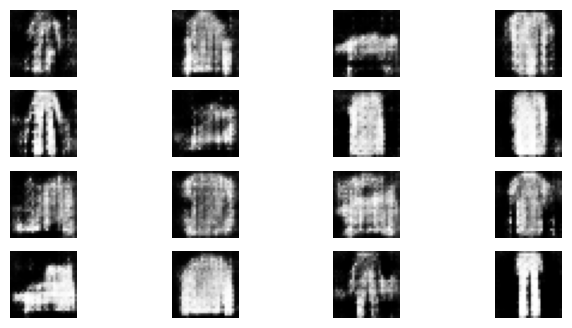

  2%|▏         | 1/50 [00:56<46:17, 56.68s/it]

Time for epoch 1 is 56.678916931152344 sec
Training started with epochs 2 with 1875 bateches...
Losses after epoch     2: generator 0.901, discriminator 1.384,  real_score 48.89%, fake_score 42.83%


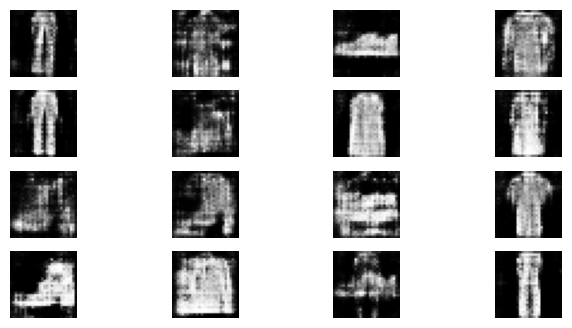

  4%|▍         | 2/50 [01:45<41:43, 52.16s/it]

Time for epoch 2 is 48.97319054603577 sec
Training started with epochs 3 with 1875 bateches...
Losses after epoch     3: generator 1.001, discriminator 1.290,  real_score 49.12%, fake_score 39.36%


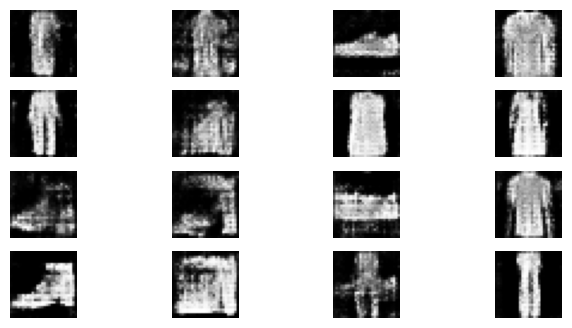

  6%|▌         | 3/50 [02:34<39:50, 50.86s/it]

Time for epoch 3 is 49.314478635787964 sec
Training started with epochs 4 with 1875 bateches...
Losses after epoch     4: generator 0.808, discriminator 1.210,  real_score 57.29%, fake_score 45.88%


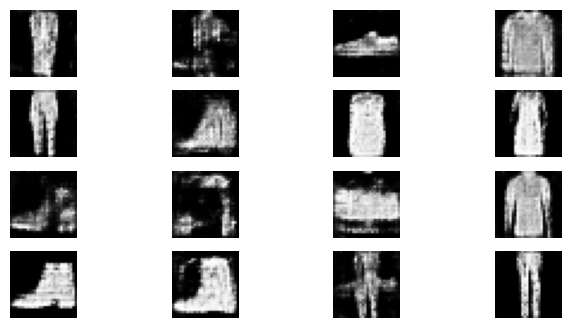

  8%|▊         | 4/50 [03:24<38:34, 50.31s/it]

Time for epoch 4 is 49.4694926738739 sec
Training started with epochs 5 with 1875 bateches...
Losses after epoch     5: generator 0.789, discriminator 1.306,  real_score 53.35%, fake_score 46.80%


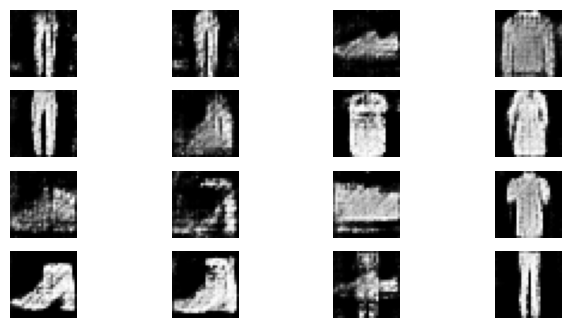

 10%|█         | 5/50 [04:14<37:33, 50.09s/it]

Time for epoch 5 is 49.6795608997345 sec
Training started with epochs 6 with 1875 bateches...
Losses after epoch     6: generator 0.892, discriminator 1.227,  real_score 55.11%, fake_score 44.03%


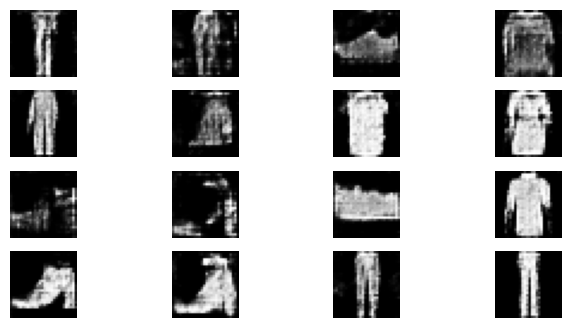

 12%|█▏        | 6/50 [05:03<36:38, 49.97s/it]

Time for epoch 6 is 49.748547077178955 sec
Training started with epochs 7 with 1875 bateches...
Losses after epoch     7: generator 0.734, discriminator 1.520,  real_score 44.83%, fake_score 48.99%


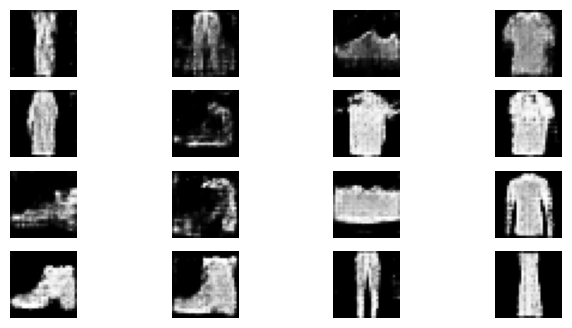

 14%|█▍        | 7/50 [05:54<35:54, 50.11s/it]

Time for epoch 7 is 50.37821006774902 sec
Training started with epochs 8 with 1875 bateches...
Losses after epoch     8: generator 0.807, discriminator 1.275,  real_score 53.47%, fake_score 45.78%


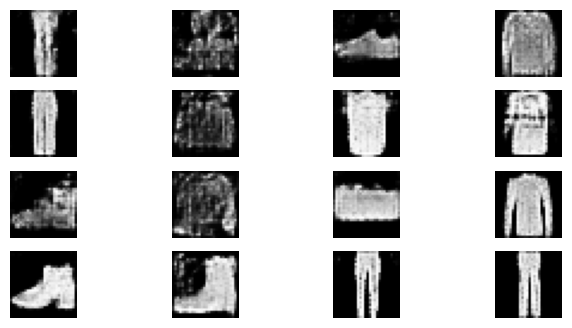

 16%|█▌        | 8/50 [06:44<35:01, 50.05s/it]

Time for epoch 8 is 49.91933751106262 sec
Training started with epochs 9 with 1875 bateches...
Losses after epoch     9: generator 0.727, discriminator 1.392,  real_score 50.98%, fake_score 49.34%


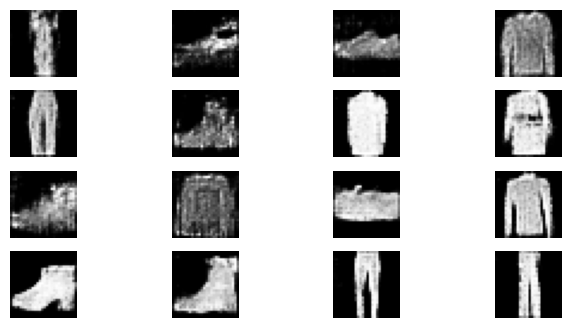

 18%|█▊        | 9/50 [07:34<34:10, 50.01s/it]

Time for epoch 9 is 49.93414926528931 sec
Training started with epochs 10 with 1875 bateches...
Losses after epoch    10: generator 0.807, discriminator 1.368,  real_score 50.45%, fake_score 46.81%


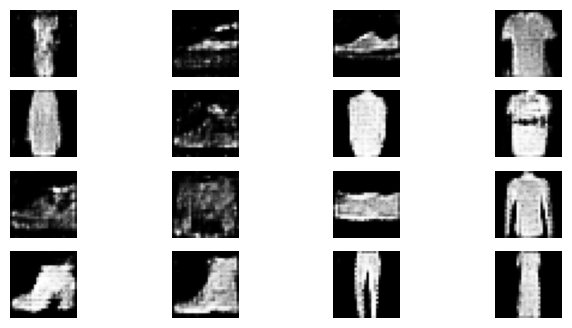

 20%|██        | 10/50 [08:24<33:24, 50.11s/it]

Time for epoch 10 is 50.33445739746094 sec
Training started with epochs 11 with 1875 bateches...
Losses after epoch    11: generator 0.711, discriminator 1.410,  real_score 52.00%, fake_score 50.48%


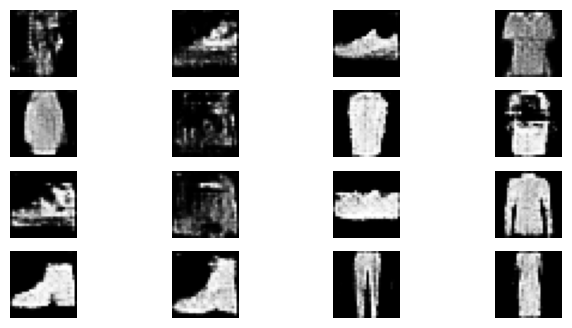

 22%|██▏       | 11/50 [09:14<32:35, 50.15s/it]

Time for epoch 11 is 50.230149030685425 sec
Training started with epochs 12 with 1875 bateches...
Losses after epoch    12: generator 0.759, discriminator 1.343,  real_score 52.26%, fake_score 47.73%


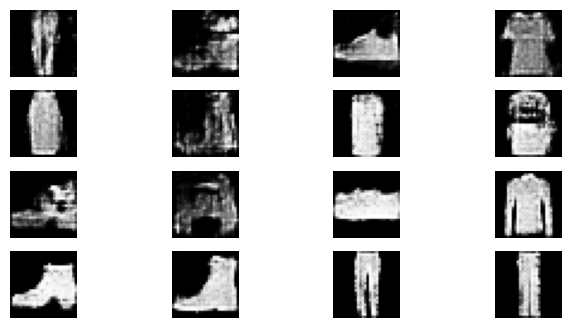

 24%|██▍       | 12/50 [10:04<31:43, 50.08s/it]

Time for epoch 12 is 49.92772340774536 sec
Training started with epochs 13 with 1875 bateches...
Losses after epoch    13: generator 0.873, discriminator 1.322,  real_score 49.69%, fake_score 43.43%


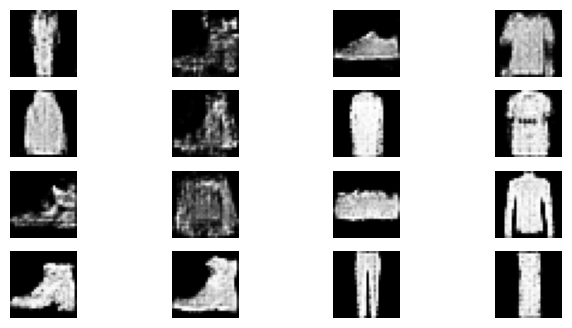

 26%|██▌       | 13/50 [10:54<30:52, 50.06s/it]

Time for epoch 13 is 49.9913535118103 sec
Training started with epochs 14 with 1875 bateches...
Losses after epoch    14: generator 0.958, discriminator 1.187,  real_score 52.45%, fake_score 39.58%


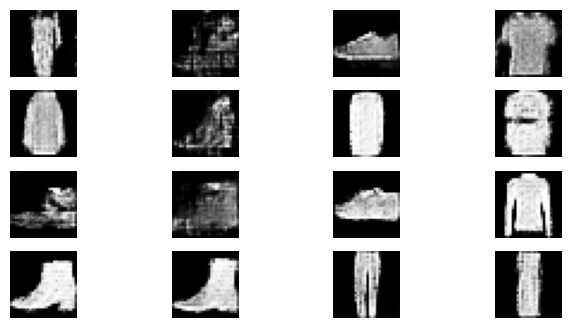

 28%|██▊       | 14/50 [11:44<30:01, 50.05s/it]

Time for epoch 14 is 50.02758049964905 sec
Training started with epochs 15 with 1875 bateches...
Losses after epoch    15: generator 0.814, discriminator 1.257,  real_score 54.84%, fake_score 45.93%


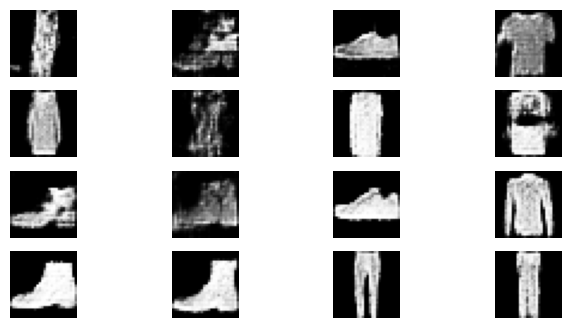

 30%|███       | 15/50 [12:34<29:10, 50.01s/it]

Time for epoch 15 is 49.93132424354553 sec
Training started with epochs 16 with 1875 bateches...
Losses after epoch    16: generator 0.894, discriminator 1.156,  real_score 55.99%, fake_score 41.83%


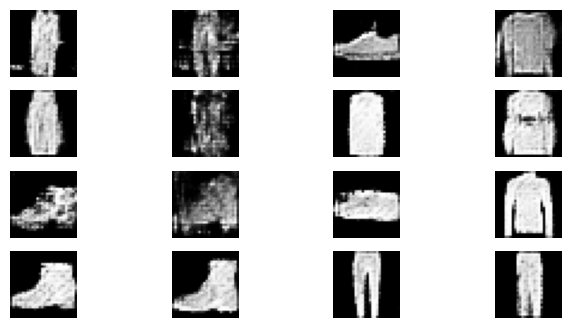

 32%|███▏      | 16/50 [13:24<28:23, 50.09s/it]

Time for epoch 16 is 50.261075019836426 sec
Training started with epochs 17 with 1875 bateches...
Losses after epoch    17: generator 0.904, discriminator 1.405,  real_score 46.08%, fake_score 42.76%


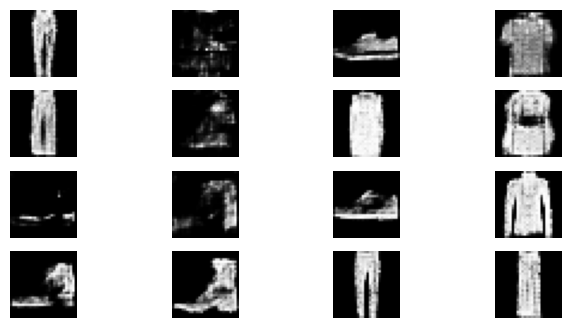

 34%|███▍      | 17/50 [14:15<27:34, 50.14s/it]

Time for epoch 17 is 50.26042699813843 sec
Training started with epochs 18 with 1875 bateches...
Losses after epoch    18: generator 1.085, discriminator 1.244,  real_score 46.26%, fake_score 35.27%


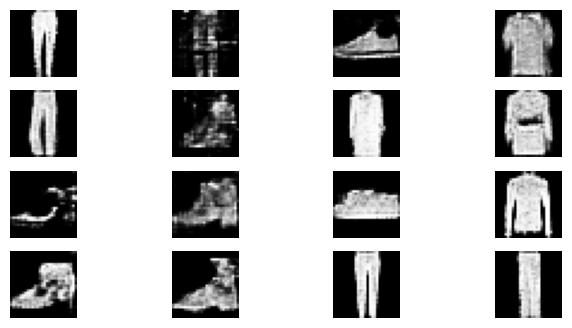

 36%|███▌      | 18/50 [15:05<26:43, 50.10s/it]

Time for epoch 18 is 50.008551359176636 sec
Training started with epochs 19 with 1875 bateches...
Losses after epoch    19: generator 0.512, discriminator 1.512,  real_score 60.08%, fake_score 60.93%


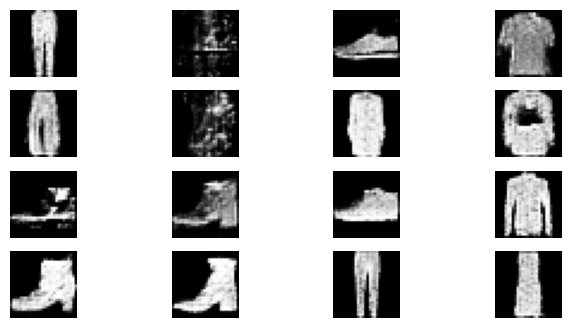

 38%|███▊      | 19/50 [15:55<25:52, 50.08s/it]

Time for epoch 19 is 50.037874937057495 sec
Training started with epochs 20 with 1875 bateches...
Losses after epoch    20: generator 0.719, discriminator 1.177,  real_score 64.98%, fake_score 49.78%


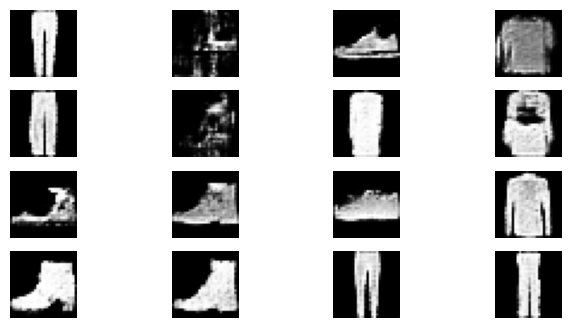

 40%|████      | 20/50 [16:45<25:06, 50.23s/it]

Time for epoch 20 is 50.556498765945435 sec
Training started with epochs 21 with 1875 bateches...
Losses after epoch    21: generator 0.811, discriminator 1.140,  real_score 62.12%, fake_score 46.17%


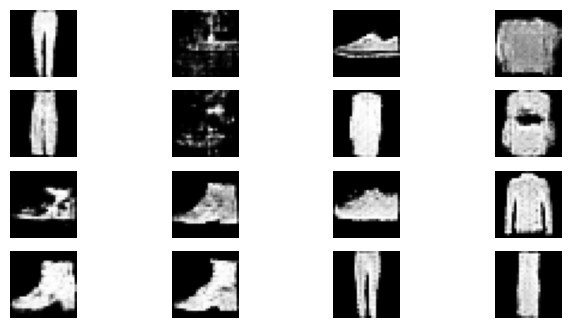

 42%|████▏     | 21/50 [17:35<24:14, 50.14s/it]

Time for epoch 21 is 49.943703413009644 sec
Training started with epochs 22 with 1875 bateches...
Losses after epoch    22: generator 0.898, discriminator 1.274,  real_score 50.26%, fake_score 41.82%


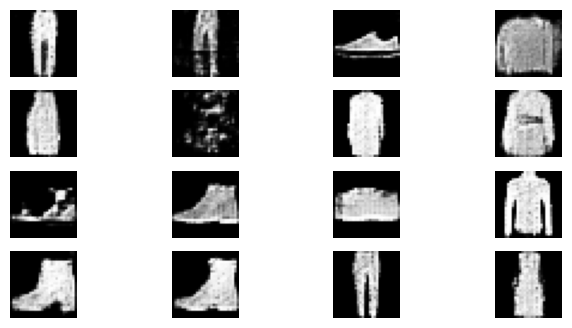

 44%|████▍     | 22/50 [18:25<23:22, 50.10s/it]

Time for epoch 22 is 50.000985622406006 sec
Training started with epochs 23 with 1875 bateches...
Losses after epoch    23: generator 0.748, discriminator 1.412,  real_score 50.18%, fake_score 48.64%


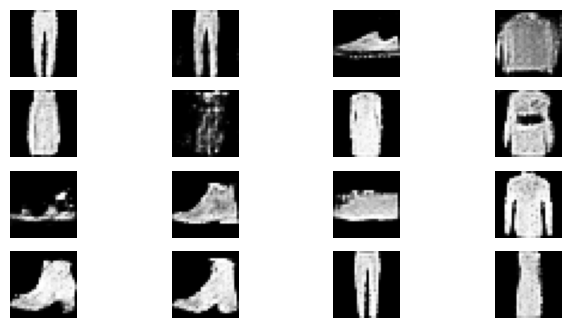

 46%|████▌     | 23/50 [19:15<22:32, 50.07s/it]

Time for epoch 23 is 50.0087206363678 sec
Training started with epochs 24 with 1875 bateches...
Losses after epoch    24: generator 0.799, discriminator 1.369,  real_score 51.38%, fake_score 47.05%


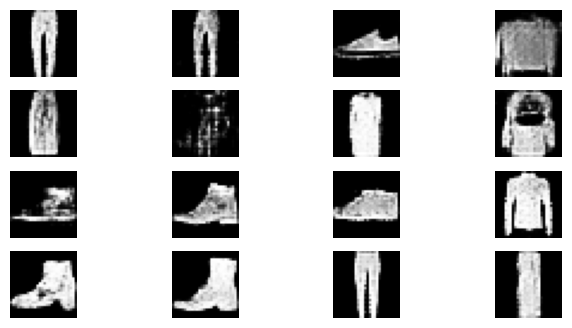

 48%|████▊     | 24/50 [20:06<21:43, 50.14s/it]

Time for epoch 24 is 50.30431509017944 sec
Training started with epochs 25 with 1875 bateches...
Losses after epoch    25: generator 0.763, discriminator 1.277,  real_score 56.01%, fake_score 48.11%


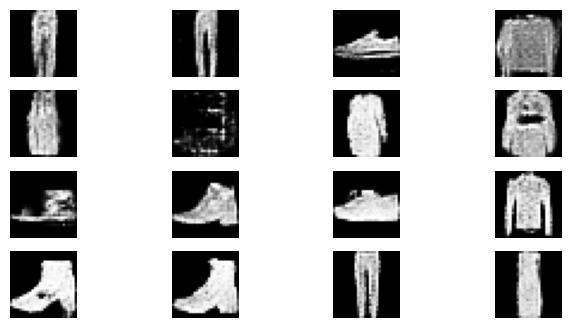

 50%|█████     | 25/50 [20:56<20:52, 50.11s/it]

Time for epoch 25 is 50.03632688522339 sec
Training started with epochs 26 with 1875 bateches...
Losses after epoch    26: generator 0.884, discriminator 1.497,  real_score 41.02%, fake_score 42.86%


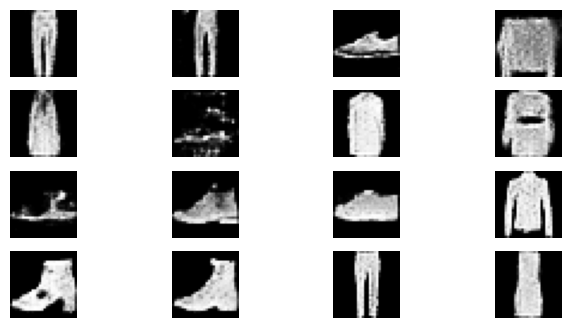

 52%|█████▏    | 26/50 [21:46<20:02, 50.09s/it]

Time for epoch 26 is 50.01919651031494 sec
Training started with epochs 27 with 1875 bateches...
Losses after epoch    27: generator 0.779, discriminator 1.185,  real_score 62.47%, fake_score 47.61%


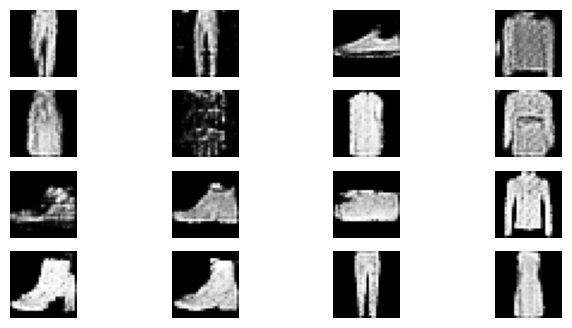

 54%|█████▍    | 27/50 [22:36<19:12, 50.11s/it]

Time for epoch 27 is 50.15668535232544 sec
Training started with epochs 28 with 1875 bateches...
Losses after epoch    28: generator 0.717, discriminator 1.319,  real_score 56.27%, fake_score 50.41%


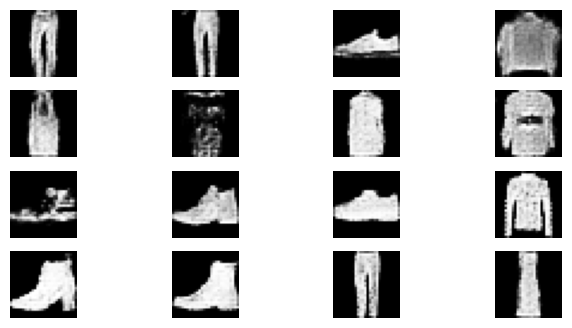

 56%|█████▌    | 28/50 [23:26<18:21, 50.08s/it]

Time for epoch 28 is 50.019800424575806 sec
Training started with epochs 29 with 1875 bateches...
Losses after epoch    29: generator 0.734, discriminator 1.553,  real_score 44.26%, fake_score 49.59%


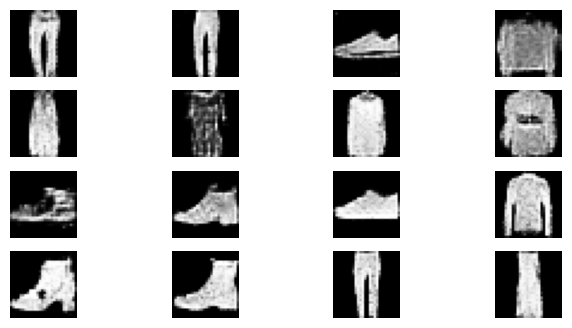

 58%|█████▊    | 29/50 [24:16<17:33, 50.14s/it]

Time for epoch 29 is 50.27563524246216 sec
Training started with epochs 30 with 1875 bateches...
Losses after epoch    30: generator 1.051, discriminator 1.214,  real_score 49.64%, fake_score 36.41%


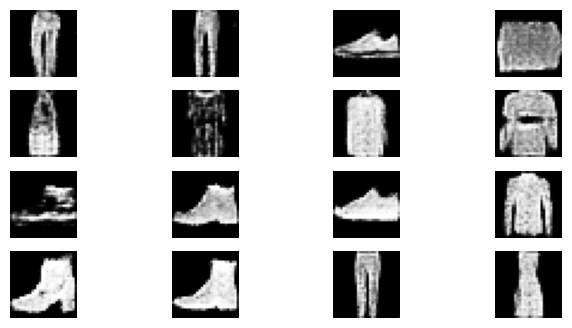

 60%|██████    | 30/50 [25:07<16:45, 50.27s/it]

Time for epoch 30 is 50.561989545822144 sec
Training started with epochs 31 with 1875 bateches...
Losses after epoch    31: generator 0.890, discriminator 1.192,  real_score 57.39%, fake_score 43.23%


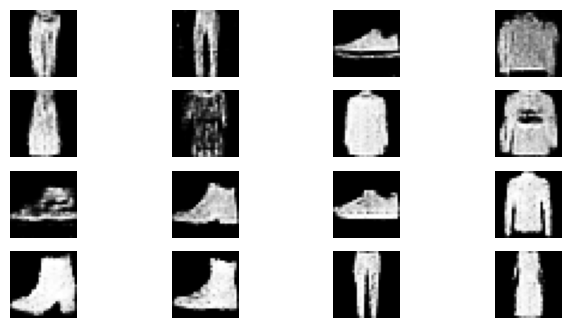

 62%|██████▏   | 31/50 [25:57<15:53, 50.20s/it]

Time for epoch 31 is 50.02680778503418 sec
Training started with epochs 32 with 1875 bateches...
Losses after epoch    32: generator 0.848, discriminator 1.243,  real_score 56.04%, fake_score 44.93%


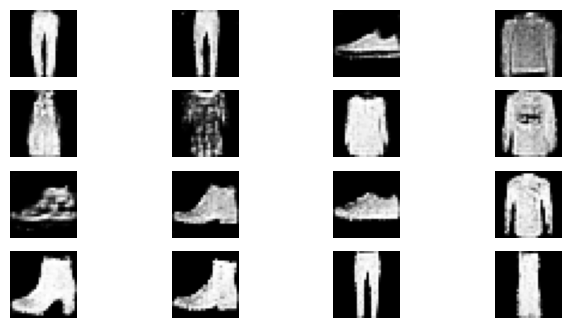

 64%|██████▍   | 32/50 [26:47<15:02, 50.14s/it]

Time for epoch 32 is 49.99051523208618 sec
Training started with epochs 33 with 1875 bateches...
Losses after epoch    33: generator 0.886, discriminator 1.373,  real_score 45.91%, fake_score 42.63%


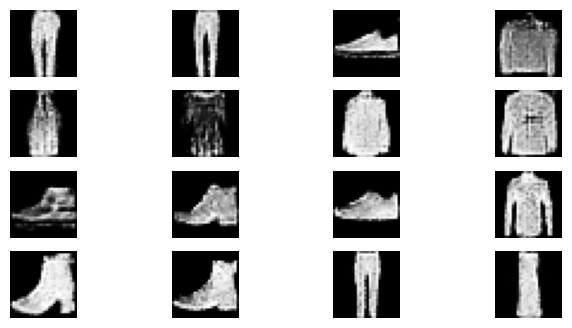

 66%|██████▌   | 33/50 [27:37<14:12, 50.12s/it]

Time for epoch 33 is 50.09019756317139 sec
Training started with epochs 34 with 1875 bateches...
Losses after epoch    34: generator 0.773, discriminator 1.088,  real_score 66.78%, fake_score 47.45%


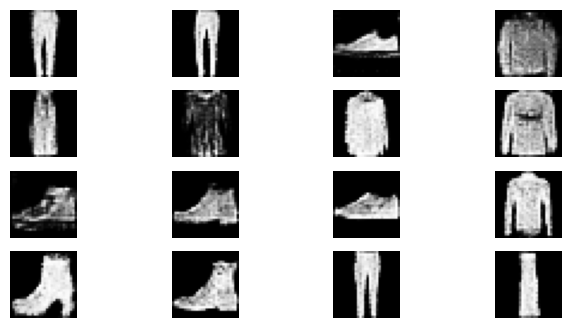

 68%|██████▊   | 34/50 [28:27<13:22, 50.17s/it]

Time for epoch 34 is 50.29031562805176 sec
Training started with epochs 35 with 1875 bateches...
Losses after epoch    35: generator 0.879, discriminator 1.392,  real_score 47.28%, fake_score 43.61%


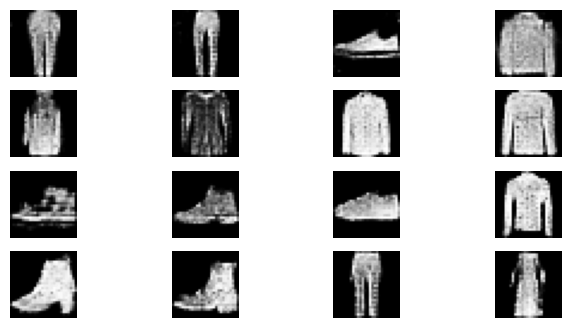

 70%|███████   | 35/50 [29:17<12:32, 50.14s/it]

Time for epoch 35 is 50.062522649765015 sec
Training started with epochs 36 with 1875 bateches...
Losses after epoch    36: generator 1.138, discriminator 0.910,  real_score 63.77%, fake_score 33.93%


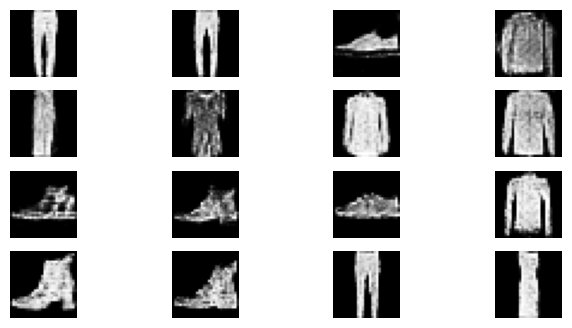

 72%|███████▏  | 36/50 [30:07<11:41, 50.11s/it]

Time for epoch 36 is 50.04314064979553 sec
Training started with epochs 37 with 1875 bateches...
Losses after epoch    37: generator 0.808, discriminator 1.445,  real_score 46.70%, fake_score 46.48%


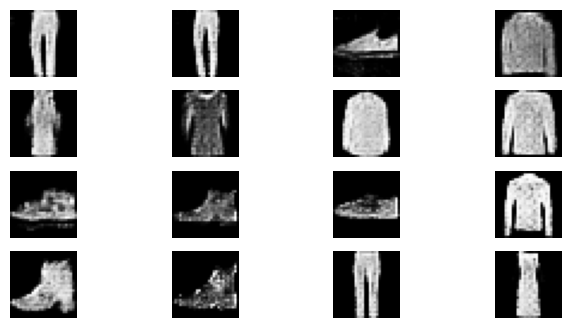

 74%|███████▍  | 37/50 [30:57<10:51, 50.10s/it]

Time for epoch 37 is 50.059579610824585 sec
Training started with epochs 38 with 1875 bateches...
Losses after epoch    38: generator 0.776, discriminator 1.609,  real_score 40.47%, fake_score 46.77%


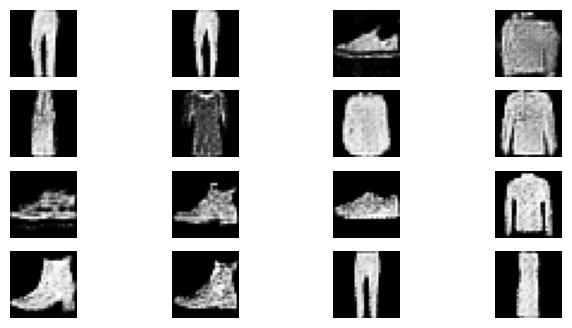

 76%|███████▌  | 38/50 [31:47<10:01, 50.16s/it]

Time for epoch 38 is 50.29787755012512 sec
Training started with epochs 39 with 1875 bateches...
Losses after epoch    39: generator 0.652, discriminator 1.184,  real_score 69.95%, fake_score 53.78%


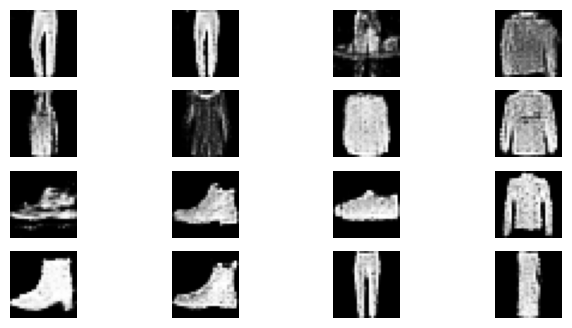

 78%|███████▊  | 39/50 [32:38<09:12, 50.19s/it]

Time for epoch 39 is 50.24961280822754 sec
Training started with epochs 40 with 1875 bateches...
Losses after epoch    40: generator 1.134, discriminator 1.384,  real_score 39.36%, fake_score 33.51%


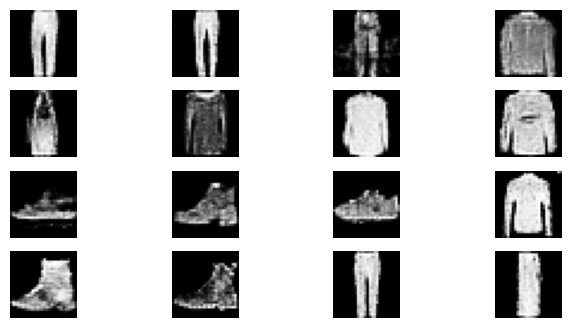

 80%|████████  | 40/50 [33:28<08:22, 50.24s/it]

Time for epoch 40 is 50.36552286148071 sec
Training started with epochs 41 with 1875 bateches...
Losses after epoch    41: generator 0.728, discriminator 1.501,  real_score 48.25%, fake_score 50.03%


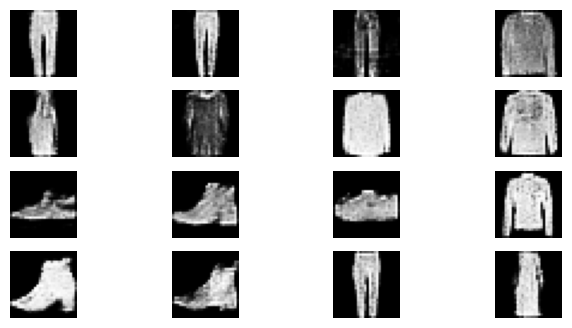

 82%|████████▏ | 41/50 [34:18<07:31, 50.17s/it]

Time for epoch 41 is 49.98969793319702 sec
Training started with epochs 42 with 1875 bateches...
Losses after epoch    42: generator 0.968, discriminator 0.912,  real_score 70.20%, fake_score 40.14%


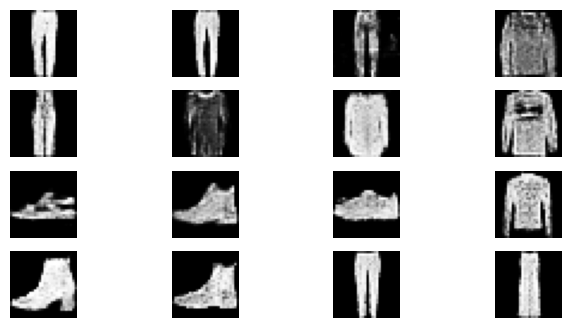

 84%|████████▍ | 42/50 [35:08<06:41, 50.23s/it]

Time for epoch 42 is 50.36427092552185 sec
Training started with epochs 43 with 1875 bateches...
Losses after epoch    43: generator 0.887, discriminator 1.142,  real_score 58.41%, fake_score 42.42%


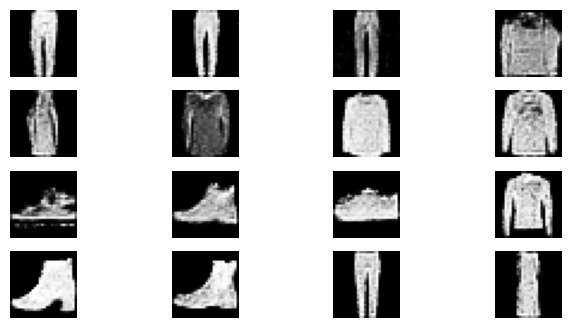

 86%|████████▌ | 43/50 [35:59<05:51, 50.23s/it]

Time for epoch 43 is 50.25134754180908 sec
Training started with epochs 44 with 1875 bateches...
Losses after epoch    44: generator 0.680, discriminator 1.433,  real_score 54.72%, fake_score 52.25%


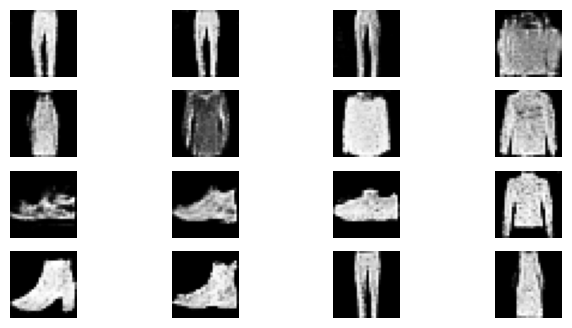

 88%|████████▊ | 44/50 [36:49<05:01, 50.17s/it]

Time for epoch 44 is 50.00952649116516 sec
Training started with epochs 45 with 1875 bateches...
Losses after epoch    45: generator 0.464, discriminator 1.303,  real_score 80.19%, fake_score 63.98%


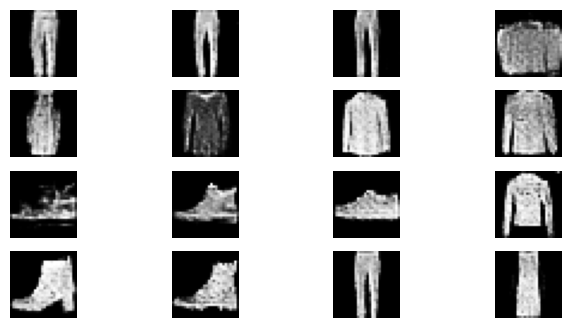

 90%|█████████ | 45/50 [37:39<04:10, 50.12s/it]

Time for epoch 45 is 50.010514974594116 sec
Training started with epochs 46 with 1875 bateches...
Losses after epoch    46: generator 0.855, discriminator 1.345,  real_score 48.94%, fake_score 43.96%


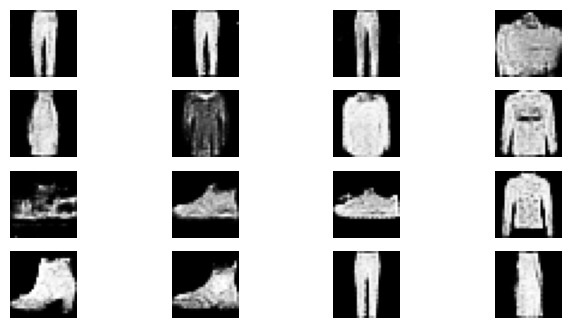

 92%|█████████▏| 46/50 [38:29<03:20, 50.13s/it]

Time for epoch 46 is 50.12801194190979 sec
Training started with epochs 47 with 1875 bateches...
Losses after epoch    47: generator 0.927, discriminator 1.151,  real_score 55.61%, fake_score 40.83%


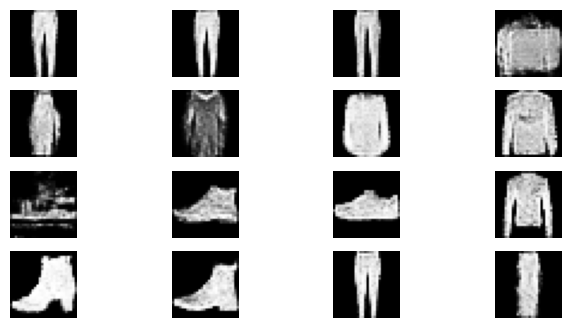

 94%|█████████▍| 47/50 [39:19<02:30, 50.20s/it]

Time for epoch 47 is 50.38120889663696 sec
Training started with epochs 48 with 1875 bateches...
Losses after epoch    48: generator 0.776, discriminator 1.299,  real_score 56.01%, fake_score 47.91%


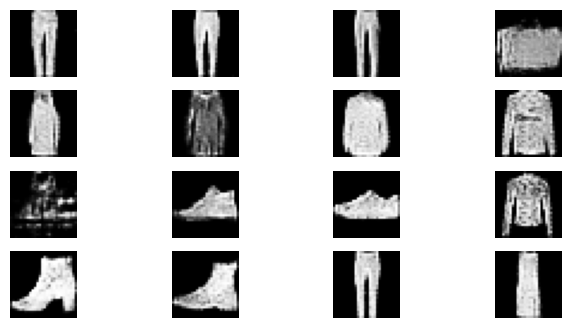

 96%|█████████▌| 48/50 [40:09<01:40, 50.16s/it]

Time for epoch 48 is 50.030261278152466 sec
Training started with epochs 49 with 1875 bateches...
Losses after epoch    49: generator 0.950, discriminator 0.944,  real_score 67.93%, fake_score 40.53%


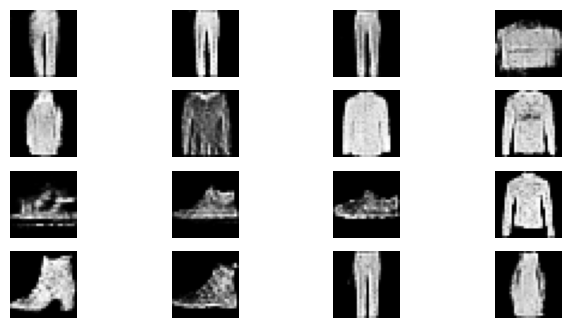

 98%|█████████▊| 49/50 [40:59<00:50, 50.13s/it]

Time for epoch 49 is 50.071136474609375 sec
Training started with epochs 50 with 1875 bateches...
Losses after epoch    50: generator 0.693, discriminator 1.374,  real_score 55.94%, fake_score 51.44%


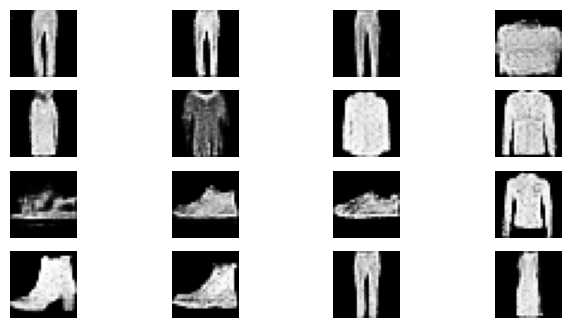

100%|██████████| 50/50 [41:50<00:00, 50.20s/it]

Time for epoch 50 is 50.3038911819458 sec


In [49]:
# start training process
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list=train(train_dataset,epochs=epochs)

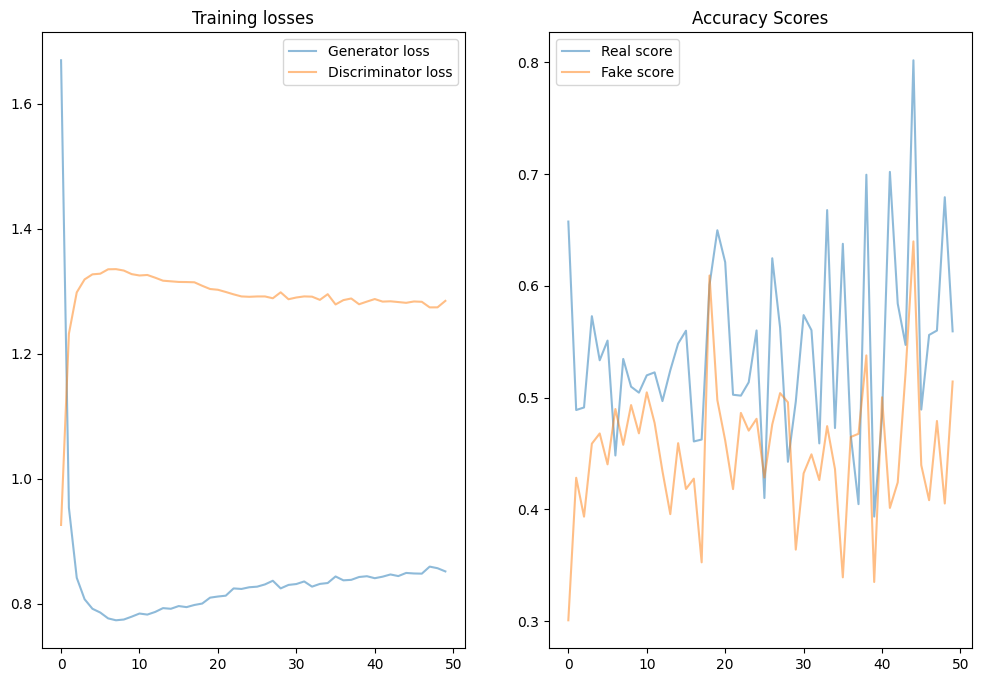

In [50]:
# generated images from the generator improves over time
# discriminator performance becomes worse over time (its loss increases over time)
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

ax1.plot(gen_loss_epochs, label='Generator loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label='Discriminator loss', alpha=0.5)
ax1.set_title('Training losses')
ax1.legend()

ax2.plot(real_score_list, label='Real score',alpha=0.5)
ax2.plot(fake_score_list, label='Fake score',alpha=0.5)
ax2.set_title('Accuracy Scores')
ax2.legend()